In [1]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src/utils')
import ipdb
import itertools
from collections import Counter


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from scipy.spatial.distance import cdist

from data import preprocessing

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Variables


In [3]:
num_topics = 15
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

# Data loading and preparation

## load

In [4]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus
corpus = load_data()

## preprocess
TODO: save after preprocessing so that there is no need to wait for a long time

In [5]:
corpus = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15
)

Dropping 0 entries of corpus, due to nan ...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
19it [00:00, 146.15it/s]

Starting tokenization ...


1261it [00:09, 139.08it/s]


### tfidf

The TfidfVectorizer does additionally also tokenization and stop word removal.

In [6]:
vectorizer_sklearn = TfidfVectorizer(stop_words='english')
tfidf_corpus_sklearn_preprocessed = vectorizer_sklearn.fit_transform(corpus["abstract"])

Since we implemented our own preprocessing this is not necessary. Therefore we don't use tokenization and lowercase. Since we didn't implement stop word removal yet(TODO: false -> remove stopword removal by sklearn) we use the stopword removal by sklearn.

In [7]:
def identity_tokenizer(text):
    return text

def get_tfidf_corpus(corpus):
    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)  
    return vectorizer, vectorizer.fit_transform(corpus["token"])

vectorizer, tfidf_corpus = get_tfidf_corpus(corpus)

## get optimal k

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


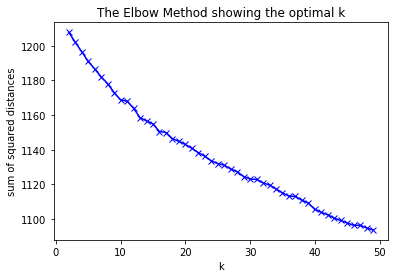

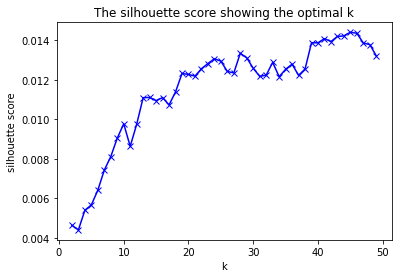

In [7]:
def find_k(corpus, num_topics):
    sum_of_suared_distances = []
    silhouette_scores = []
    K = range(2,num_topics)
    for k in K:
        model = KMeans(n_clusters=k, random_state=10)
        model.fit(corpus)
        sum_of_suared_distances.append(model.inertia_)
        labels = model.labels_
        silhouette_scores.append(metrics.silhouette_score(tfidf_corpus, labels, metric='euclidean'))

    # Plot the elbow
    plt.plot(K, sum_of_suared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('sum of squared distances')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

    # Plot silhouette scores
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.title('The silhouette score showing the optimal k')
    plt.show()
find_k(tfidf_corpus, 50)

 There is no elbow visible. There could be several reasons for this: https://stats.stackexchange.com/questions/89679/what-do-you-do-when-theres-no-elbow-point-for-kmeans-clustering

Silhouette score explained:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
TODO: proper visualization of silhouette score

Elbow Method explained: https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/

# Clustering

In [8]:
def fit_model(model, corpus):
    model.fit(corpus)

def print_and_get_clusters(model, vectorizer, n_components=None, svd=None):
    print("Top terms per cluster:")
    if n_components:
        original_space_centroids = svd.inverse_transform(model.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    clusters = []
    for i in range(num_topics):
        print("Cluster %d:" % i),
        cluster = []
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
            cluster.append(terms[ind])
        clusters.append(cluster)
        print("\n")
    return clusters
    
model = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model, tfidf_corpus)
clusters = print_and_get_clusters(model, vectorizer)


Top terms per cluster:
Cluster 0:
 learning
 model
 data
 algorithm
 method
 problem
 framework
 time
 task
 clustering


Cluster 1:
 kernel
 learning
 function
 space
 hilbert
 regression
 data
 rkhs
 reproducing
 based


Cluster 2:
 inference
 model
 gaussian
 variational
 bayesian
 process
 posterior
 approximation
 distribution
 prior


Cluster 3:
 feature
 bound
 label
 class
 density
 dimension
 sample
 rate
 classifier
 data


Cluster 4:
 matrix
 rank
 low
 completion
 norm
 factorization
 sampling
 method
 bound
 covariance


Cluster 5:
 regression
 loss
 function
 lasso
 linear
 estimator
 method
 algorithm
 distributed
 model


Cluster 6:
 policy
 regret
 learning
 action
 agent
 reinforcement
 reward
 decision
 algorithm
 bandit


Cluster 7:
 machine
 svm
 estimator
 vector
 support
 data
 classification
 learning
 distributed
 model


Cluster 8:
 causal
 effect
 variable
 data
 cause
 discovery
 observational
 model
 instrumental
 treatment


Cluster 9:
 optimization
 stoch

Since the words which define the clusters look weird I use the sklearn preprocessing in the following. Our preprocessing should be improved. Or we decide to just use the sklearn preprocessing. But as far as I know they don't use lemmatization and stemming (TODO: true?)
With no stemming, the use of nltk and lowering the words, the result seems to be better. Therfore we use our own preprocessing again.

In [29]:
model_skelarn_preprocessed = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model_skelarn_preprocessed, tfidf_corpus_sklearn_preprocessed)
print_and_get_clusters(model_skelarn_preprocessed, vectorizer_sklearn)


Top terms per cluster:
Cluster 0:
 variational
 inference
 gaussian
 process
 approximation
 gabp
 models
 model
 bayesian
 latent


Cluster 1:
 graphical
 models
 model
 lasso
 data
 covariance
 high
 estimation
 sparse
 dimensional


Cluster 2:
 feature
 features
 gesture
 selection
 data
 recognition
 learning
 training
 model
 transfer


Cluster 3:
 learning
 data
 algorithms
 models
 graph
 model
 inference
 algorithm
 bayesian
 based


Cluster 4:
 neural
 networks
 deep
 network
 learning
 layer
 convolutional
 layers
 training
 data


Cluster 5:
 classification
 svm
 learning
 machine
 library
 data
 python
 vector
 classifiers
 support


Cluster 6:
 causal
 variables
 effect
 effects
 discovery
 data
 observational
 instrumental
 lpcc
 inference


Cluster 7:
 optimization
 stochastic
 gradient
 convex
 convergence
 algorithms
 algorithm
 problems
 descent
 online


Cluster 8:
 entries
 completion
 sampling
 matrix
 rank
 nyström
 combinatorial
 quantum
 algebraic
 mpr


Cluster

[['variational',
  'inference',
  'gaussian',
  'process',
  'approximation',
  'gabp',
  'models',
  'model',
  'bayesian',
  'latent'],
 ['graphical',
  'models',
  'model',
  'lasso',
  'data',
  'covariance',
  'high',
  'estimation',
  'sparse',
  'dimensional'],
 ['feature',
  'features',
  'gesture',
  'selection',
  'data',
  'recognition',
  'learning',
  'training',
  'model',
  'transfer'],
 ['learning',
  'data',
  'algorithms',
  'models',
  'graph',
  'model',
  'inference',
  'algorithm',
  'bayesian',
  'based'],
 ['neural',
  'networks',
  'deep',
  'network',
  'learning',
  'layer',
  'convolutional',
  'layers',
  'training',
  'data'],
 ['classification',
  'svm',
  'learning',
  'machine',
  'library',
  'data',
  'python',
  'vector',
  'classifiers',
  'support'],
 ['causal',
  'variables',
  'effect',
  'effects',
  'discovery',
  'data',
  'observational',
  'instrumental',
  'lpcc',
  'inference'],
 ['optimization',
  'stochastic',
  'gradient',
  'convex',
 

lemmatization would be good, because the defining words are redundant(e.g. models and model, graphs and graph, ...)

# Visualization

TODO: merge somehow with visualization of gensim_inspections? would be very difficult because of different inputs


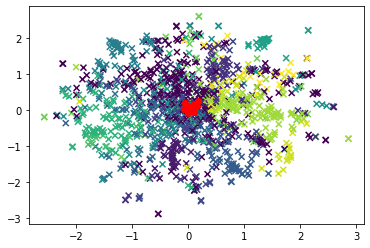

In [12]:
def plot(model, corpus, n_components=None):
    random_state = 1
    centroids = model.cluster_centers_

    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 10
    tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
        perplexity=tsne_perplexity,
        early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)
    if n_components:
        transformed = tsne.fit_transform(np.concatenate((corpus, centroids)))
    else:
        transformed = tsne.fit_transform(np.concatenate((corpus.todense(), centroids)))
    plt.scatter(transformed[:-num_topics, 0], transformed[:-num_topics, 1], c=model.labels_, marker='x')
    plt.scatter(transformed[-num_topics:, 0], transformed[-num_topics:, 1], c="red", marker='o')

    plt.show()
plot(model, tfidf_corpus)

# LSA and kmeans

In [9]:
def get_lsa_transformation(n_components, corpus):
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    return lsa.fit_transform(corpus),svd

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


n_components:  2


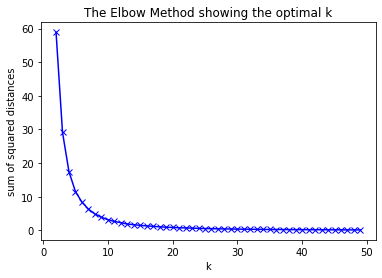

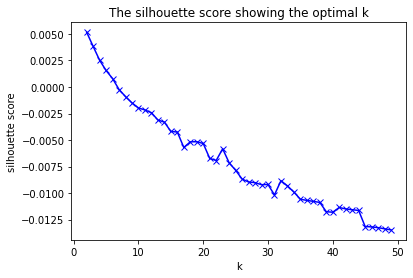

n_components:  3


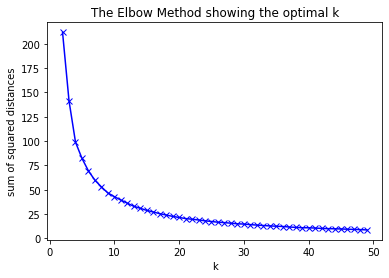

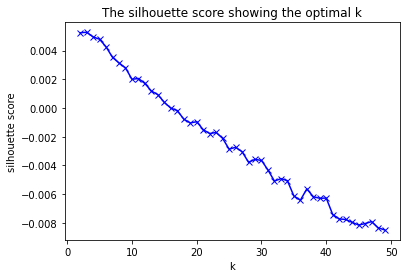

n_components:  4


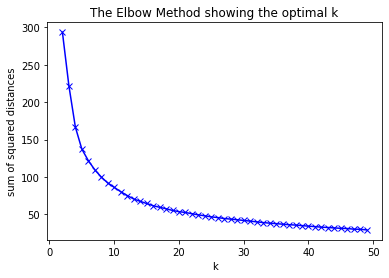

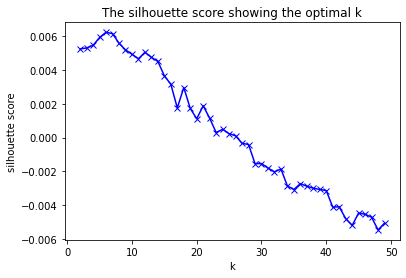

n_components:  5


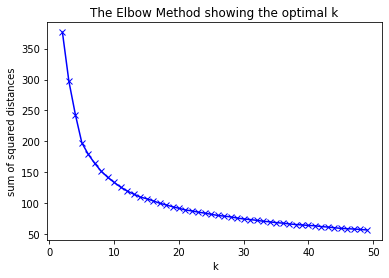

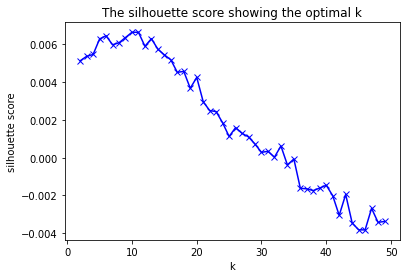

n_components:  6


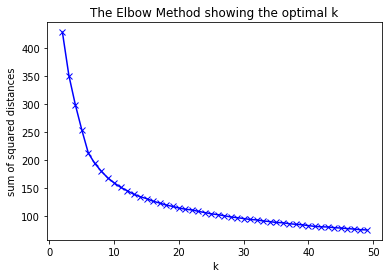

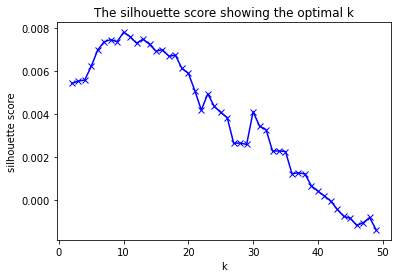

n_components:  7


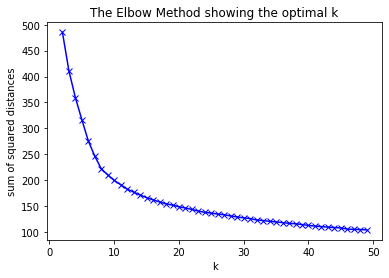

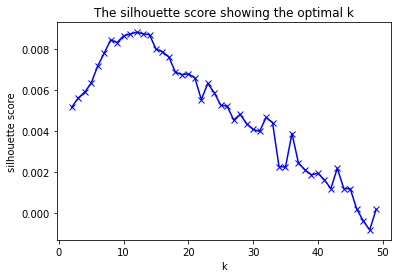

n_components:  8


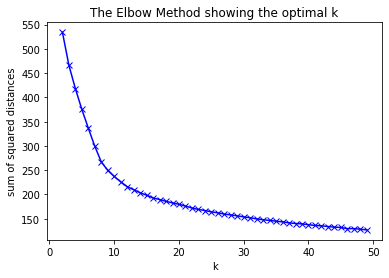

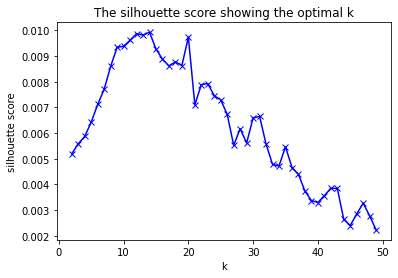

n_components:  9


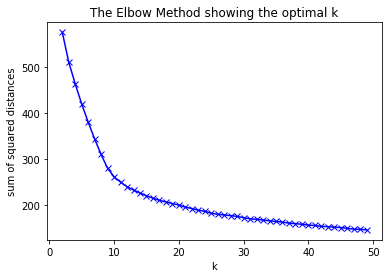

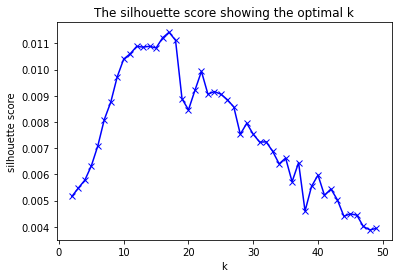

n_components:  10


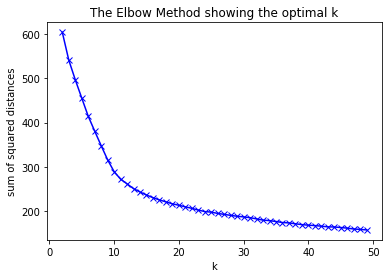

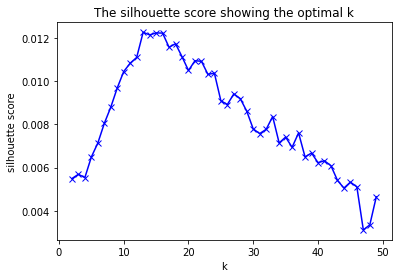

In [12]:
def find_n_components_and_k(corpus):
    for n_components in [2,3,4,5,6,7,8,9,10]:
        print("n_components: ", n_components)
        X, svd = get_lsa_transformation(n_components, corpus)
        find_k(X, 50)
        
find_n_components_and_k(tfidf_corpus)

With LSA and kmeans a elbow is visible! The peak of the silhouette score moves to the right the higher n_component.
The optimal cluster number seems to be 15? With n_components = 10 also the peak of the silhouette score is at k=15. So maybe use num_topics= 15 and n_components=9?

In [10]:
n_components = 10
X, svd = get_lsa_transformation(n_components, tfidf_corpus)
num_topics = 15
model_lsa = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model_lsa, X)
clusters_with_lsa = print_and_get_clusters(model_lsa, vectorizer, n_components=n_components, svd=svd)


Top terms per cluster:
Cluster 0:
 bound
 loss
 rate
 sample
 class
 estimator
 distribution
 optimal
 learning
 error


Cluster 1:
 model
 inference
 gaussian
 bayesian
 process
 data
 latent
 method
 variational
 distribution


Cluster 2:
 learning
 label
 algorithm
 data
 classification
 problem
 class
 bound
 classifier
 multi


Cluster 3:
 learning
 data
 machine
 feature
 library
 task
 label
 python
 classification
 algorithm


Cluster 4:
 causal
 variable
 graph
 model
 effect
 data
 graphical
 method
 inference
 learning


Cluster 5:
 matrix
 rank
 low
 completion
 norm
 bound
 tensor
 sparse
 method
 problem


Cluster 6:
 policy
 learning
 algorithm
 bound
 reinforcement
 action
 regret
 problem
 process
 distribution


Cluster 7:
 algorithm
 model
 matrix
 data
 method
 problem
 bound
 learning
 approach
 sample


Cluster 8:
 learning
 model
 data
 feature
 method
 algorithm
 set
 classification
 machine
 approach


Cluster 9:
 kernel
 learning
 regression
 function
 estimat

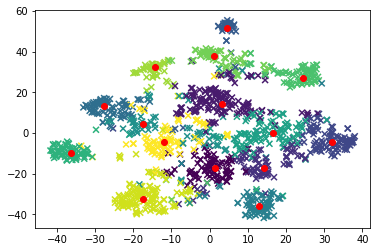

In [13]:
plot(model_lsa, X, n_components=n_components)

cluster centers look better than without lsa.

# Remove words which appear often in all clusters

In [14]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'model': 9, 'data': 8, 'algorithm': 7, 'learning': 5, 'method': 5, 'function': 3, 'regression': 3, 'problem': 2, 'gaussian': 2, 'process': 2, 'bound': 2, 'class': 2, 'estimator': 2, 'distributed': 2, 'variable': 2, 'optimization': 2, 'stochastic': 2, 'gradient': 2, 'convergence': 2, 'graph': 2, 'framework': 1, 'time': 1, 'task': 1, 'clustering': 1, 'kernel': 1, 'space': 1, 'hilbert': 1, 'rkhs': 1, 'reproducing': 1, 'based': 1, 'inference': 1, 'variational': 1, 'bayesian': 1, 'posterior': 1, 'approximation': 1, 'distribution': 1, 'prior': 1, 'feature': 1, 'label': 1, 'density': 1, 'dimension': 1, 'sample': 1, 'rate': 1, 'classifier': 1, 'matrix': 1, 'rank': 1, 'low': 1, 'completion': 1, 'norm': 1, 'factorization': 1, 'sampling': 1, 'covariance': 1, 'loss': 1, 'lasso': 1, 'linear': 1, 'policy': 1, 'regret': 1, 'action': 1, 'agent': 1, 'reinforcement': 1, 'reward': 1, 'decision': 1, 'bandit': 1, 'machine': 1, 'svm': 1, 'vector': 1, 'support': 

In [15]:
terms = list(itertools.chain.from_iterable(clusters_with_lsa))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'data': 11, 'learning': 9, 'model': 8, 'algorithm': 8, 'method': 7, 'bound': 5, 'problem': 5, 'graph': 4, 'rate': 3, 'estimator': 3, 'distribution': 3, 'classification': 3, 'sample': 2, 'class': 2, 'inference': 2, 'process': 2, 'label': 2, 'machine': 2, 'feature': 2, 'causal': 2, 'variable': 2, 'graphical': 2, 'matrix': 2, 'tensor': 2, 'approach': 2, 'regression': 2, 'function': 2, 'network': 2, 'node': 2, 'clustering': 2, 'cluster': 2, 'loss': 1, 'optimal': 1, 'error': 1, 'gaussian': 1, 'bayesian': 1, 'latent': 1, 'variational': 1, 'classifier': 1, 'multi': 1, 'library': 1, 'task': 1, 'python': 1, 'effect': 1, 'rank': 1, 'low': 1, 'completion': 1, 'norm': 1, 'sparse': 1, 'policy': 1, 'reinforcement': 1, 'action': 1, 'regret': 1, 'set': 1, 'kernel': 1, 'space': 1, 'mean': 1, 'hilbert': 1, 'neural': 1, 'deep': 1, 'community': 1, 'structure': 1, 'density': 1, 'spectral': 1, 'point': 1, 'optimization': 1, 'gradient': 1, 'convex': 1, 'stochasti

Words that should be removed are algorithm, data, learning, method, model. This insight corresponds to the insight we get by printing the topwords of BoW and tfidf corpuses (milestone) 

In [16]:
custom_stopwords = ["algorithm", "data", "learning", "method", "model"]

In [17]:
corpus_new = load_data()

corpus_stopwords = preprocessing(
    corpus_new,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15,
    custom_stopwords = custom_stopwords
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
29it [00:00, 284.32it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:29, 42.60it/s] 


In [18]:
vectorizer_stopwords, tfidf_corpus_stopwords = get_tfidf_corpus(corpus_stopwords)

In [31]:
n_components = 10
X, svd = get_lsa_transformation(n_components, tfidf_corpus_stopwords)
num_topics = 15
model_stopwords = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model_stopwords, X)
clusters_with_lsa_stopwords = print_and_get_clusters(model_stopwords, vectorizer_stopwords, n_components=n_components, svd=svd)

Top terms per cluster:
Cluster 0:
 graph
 network
 inference
 variable
 causal
 graphical
 set
 approach
 gaussian
 distribution


Cluster 1:
 kernel
 problem
 function
 regression
 matrix
 bound
 optimization
 convex
 rate
 gradient


Cluster 2:
 kernel
 convex
 function
 regression
 rate
 bound
 optimization
 gradient
 problem
 convergence


Cluster 3:
 graph
 network
 problem
 approach
 set
 inference
 variable
 based
 distribution
 gaussian


Cluster 4:
 graph
 network
 causal
 inference
 graphical
 variable
 latent
 gaussian
 set
 bayesian


Cluster 5:
 problem
 kernel
 function
 regression
 matrix
 bound
 optimization
 convex
 rate
 approach


Cluster 6:
 problem
 matrix
 function
 graph
 network
 regression
 kernel
 approach
 based
 set


Cluster 7:
 kernel
 function
 regression
 problem
 bound
 matrix
 convex
 rate
 optimization
 gradient


Cluster 8:
 graph
 network
 inference
 causal
 variable
 graphical
 gaussian
 set
 latent
 approach


Cluster 9:
 graph
 network
 inference

In [20]:
terms = list(itertools.chain.from_iterable(clusters_with_lsa_stopwords))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'problem': 9, 'function': 9, 'network': 8, 'matrix': 5, 'rate': 5, 'bound': 5, 'policy': 5, 'graph': 4, 'variable': 4, 'kernel': 4, 'regression': 4, 'estimator': 4, 'convex': 4, 'convergence': 4, 'approach': 4, 'optimization': 4, 'gradient': 4, 'stochastic': 4, 'graphical': 3, 'feature': 3, 'bayesian': 3, 'rank': 3, 'approximation': 3, 'loss': 3, 'distribution': 3, 'set': 3, 'causal': 2, 'clustering': 2, 'cluster': 2, 'inference': 2, 'process': 2, 'time': 2, 'gaussian': 2, 'based': 2, 'low': 2, 'sparse': 2, 'density': 2, 'estimation': 2, 'node': 1, 'community': 1, 'task': 1, 'completion': 1, 'tensor': 1, 'norm': 1, 'covariance': 1, 'error': 1, 'class': 1, 'latent': 1, 'space': 1, 'mean': 1})>

Now we have other words that are in multiple clusters.

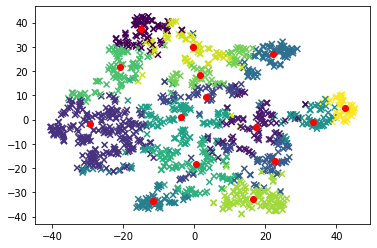

In [21]:
plot(model_stopwords, X, n_components=n_components)

The clusters look now not as good as before in my opinion. Maybe we need new k and n_components?

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


n_components:  2


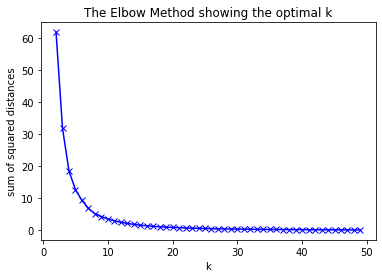

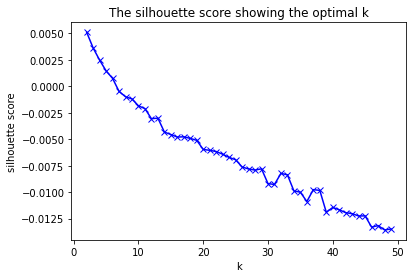

n_components:  3


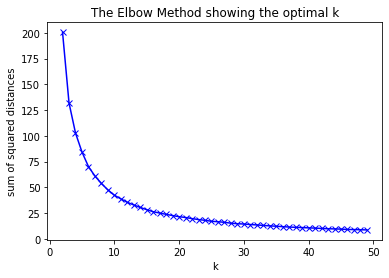

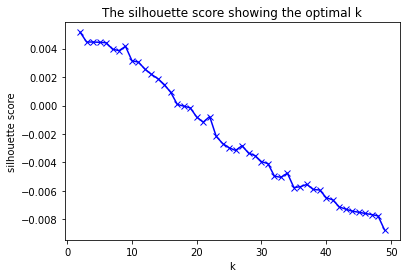

n_components:  4


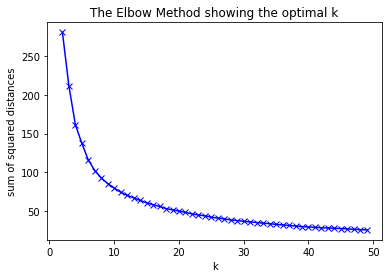

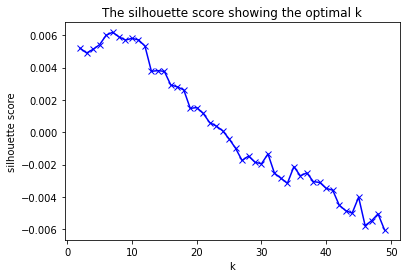

n_components:  5


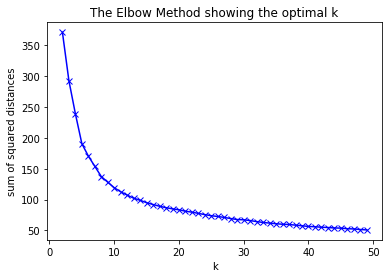

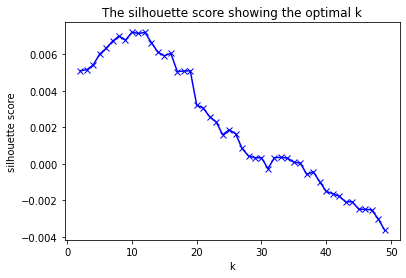

n_components:  6


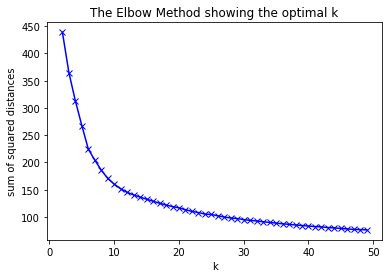

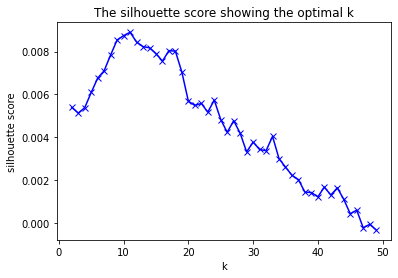

n_components:  7


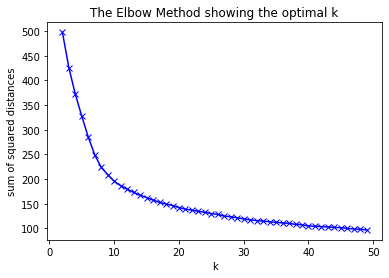

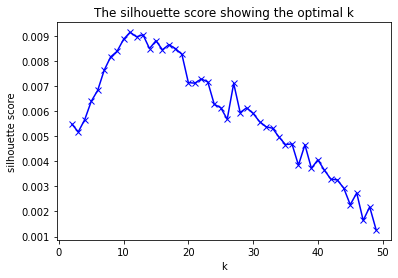

n_components:  8


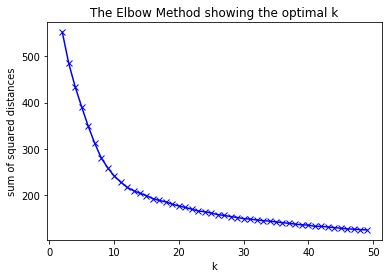

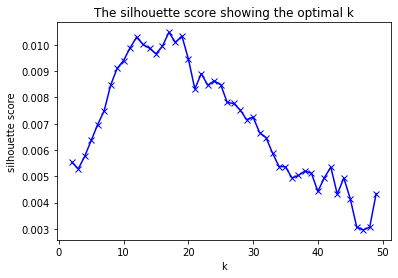

n_components:  9


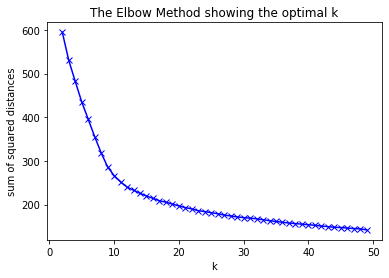

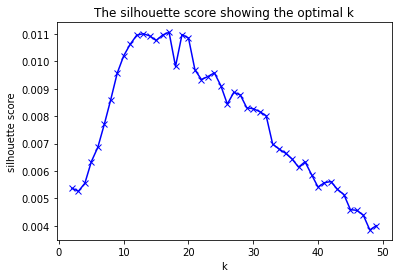

n_components:  10


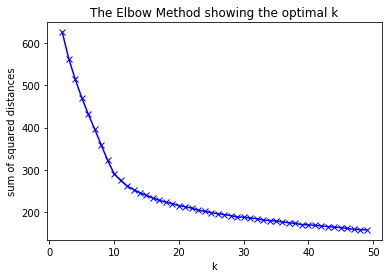

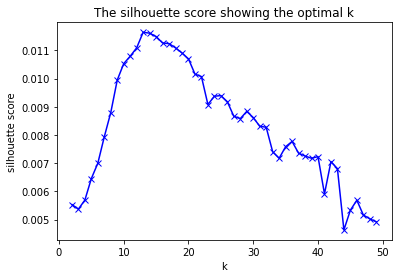

In [39]:
find_n_components_and_k(tfidf_corpus_stopwords)

Looks similar to before.

# Spectral Embedding
find optimal n_components

In [35]:
def calc_scores_arr(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus, model.labels_), metrics.davies_bouldin_score(corpus, model.labels_)

def calc_scores(corpus, model):
    return calc_scores_arr(corpus.toarray(), model)

def plot_scores(silhouettes_scores, calinski_harabasz_scores, davies_bouldin_scores, n):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.plot(n, silhouettes_scores)
    ax1.set_title('silhouettes_score')
    ax2.plot(n, calinski_harabasz_scores, label="calinski_harabasz_scores")
    ax2.set_title('calinski_harabasz_scores')
    ax3.plot(n, davies_bouldin_scores, label="davies_bouldin_scores")
    ax3.set_title('davies_bouldin_scores')
    plt.show()
    

def find_n_components_spectral():
    n = [2,5,10,15,20,25,30]
    vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
    tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(corpus["token"])
    silhouettes_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    for n_component in n:
        tfidf_corpus_spec_embedding_array = SpectralEmbedding(n_components=n_component).fit_transform(tfidf_corpus_spec_embedding.toarray())
        model_spectral = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
        model_spectral.fit(tfidf_corpus_spec_embedding_array)
        score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, model_spectral))
        silhouettes_scores.append(score[0])
        calinski_harabasz_scores.append(score[1])                         
        davies_bouldin_scores.append(score[2])                         

    plot_scores(silhouettes_scores, calinski_harabasz_scores, davies_bouldin_scores, n)

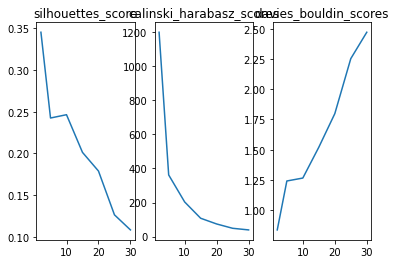

In [36]:
find_n_components_spectral()

2 is best

In [37]:
vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(corpus["token"])
spectral_embedding = SpectralEmbedding(n_components=2)
tfidf_corpus_spec_embedding_array = spectral_embedding.fit_transform(tfidf_corpus_spec_embedding.toarray())

In [38]:
model_spectral = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
model_spectral.fit(tfidf_corpus_spec_embedding_array)

KMeans(max_iter=100, n_clusters=15, n_init=1)

Getting the top terms of a cluster with the centroids is only possible, when getting the inverse spectral embedding of the centroids. Since this seems not to be possible, the top terms get extracted here the same way as in the other clustering algorithms, by getting the top words of each cluster.

In [39]:
def get_top_words(vectorizer, corpus):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(corpus.sum(axis=0)).ravel())
    sorted_scores = list(zip(*sorted(scores, key=lambda x: x[1], reverse=True)))
    top_words = sorted_scores[0][:10]
    return top_words

def print_and_get_clusters_manually(model, vectorizer, corpus, n_components=None, svd=None):
    print("Top terms per cluster:")
    clusters = []
    for i in range(np.max(model.labels_)+1):
        print("Cluster %d:" % i),
        vectorizer, tfidf_corpus = get_tfidf_corpus(corpus.iloc[np.where(model.labels_ == i)])
        top_words = get_top_words(vectorizer, tfidf_corpus)
        print(top_words)
        clusters.append(get_top_words(vectorizer, tfidf_corpus))
        print("\n")
    return clusters

In [40]:
clusters_spectral = print_and_get_clusters_manually(model_spectral, vectorizer_spec_embedding, corpus)

Top terms per cluster:
Cluster 0:
('kernel', 'learning', 'algorithm', 'data', 'class', 'method', 'problem', 'set', 'model', 'approach')


Cluster 1:
('model', 'network', 'data', 'learning', 'neural', 'inference', 'algorithm', 'graph', 'method', 'set')


Cluster 2:
('algorithm', 'data', 'model', 'method', 'kernel', 'learning', 'distribution', 'clustering', 'dimensional', 'regression')


Cluster 3:
('learning', 'python', 'library', 'data', 'machine', 'source', 'model', 'toolbox', 'scikit', 'package')


Cluster 4:
('algorithm', 'method', 'stochastic', 'convex', 'problem', 'gradient', 'optimization', 'function', 'loss', 'convergence')


Cluster 5:
('learning', 'data', 'feature', 'model', 'method', 'task', 'classifier', 'classification', 'system', 'algorithm')


Cluster 6:
('learning', 'algorithm', 'policy', 'problem', 'function', 'optimization', 'method', 'loss', 'online', 'gradient')


Cluster 7:
('model', 'data', 'feature', 'network', 'learning', 'based', 'method', 'algorithm', 'set', 'p

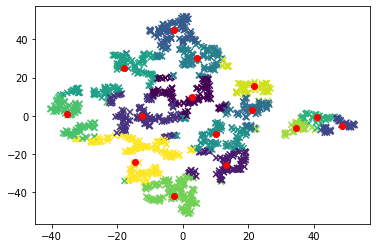

In [41]:
plot(model_spectral, tfidf_corpus_spec_embedding_array, n_components=2)

With Spectral Embedding and kmeans it looks nice clustered.

In [42]:
terms = list(itertools.chain.from_iterable(clusters_spectral))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'algorithm': 14, 'learning': 12, 'method': 12, 'data': 11, 'model': 9, 'problem': 6, 'kernel': 4, 'set': 3, 'network': 3, 'graph': 3, 'package': 3, 'optimization': 3, 'function': 3, 'approach': 2, 'neural': 2, 'inference': 2, 'clustering': 2, 'regression': 2, 'python': 2, 'library': 2, 'machine': 2, 'toolbox': 2, 'gradient': 2, 'loss': 2, 'feature': 2, 'task': 2, 'policy': 2, 'estimator': 2, 'multi': 2, 'variable': 2, 'class': 1, 'distribution': 1, 'dimensional': 1, 'source': 1, 'scikit': 1, 'stochastic': 1, 'convex': 1, 'convergence': 1, 'classifier': 1, 'classification': 1, 'system': 1, 'online': 1, 'based': 1, 'bound': 1, 'rate': 1, 'framework': 1, 'weka': 1, 'matrix': 1, 'rank': 1, 'sparse': 1, 'low': 1, 'estimation': 1, 'completion': 1, 'graphical': 1, 'causal': 1, 'latent': 1, 'image': 1, 'label': 1, 'active': 1, 'gaussian': 1})>

# Metrics

In [43]:
def calc_scores_arr(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus, model.labels_), metrics.davies_bouldin_score(corpus, model.labels_)

def calc_scores(corpus, model):
    return calc_scores_arr(corpus.toarray(), model)

scores = []
score = list(calc_scores(tfidf_corpus, model))
score.insert(0, 'normal model')
scores.append(score)

score = list(calc_scores(tfidf_corpus_sklearn_preprocessed, model_skelarn_preprocessed))
score.insert(0, 'model_skelarn_preprocessed')
scores.append(score)

score = list(calc_scores(tfidf_corpus, model_lsa))
score.insert(0, 'model_lsa')
scores.append(score)

score = list(calc_scores(tfidf_corpus_stopwords, model_stopwords))
score.insert(0, 'model_stopwords')
scores.append(score)

score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, model_spectral))
score.insert(0, 'model with spectral embedding')
scores.append(score)

scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                      model type  silhouette_score  calinski_harabasz_score  \
0                   normal model          0.007942                 4.158810   
1     model_skelarn_preprocessed          0.007730                 3.920887   
2                      model_lsa          0.012463                 4.725263   
3                model_stopwords         -0.004454                 1.924889   
4  model with spectral embedding          0.349721              1229.884082   

   davies_bouldin_score  
0              7.679101  
1              7.676880  
2              7.609132  
3             12.417936  
4              0.824825  


In [44]:
scores.to_csv("scores/kmeans.csv")